## 🧠💡 Intelligent Systems  for Smart Health 👨‍⚕👩‍⚕️🔬🌡️

# Risk Models Using Tree-based Models

In a first step, we used linear models (Linear regression, logistic regression). Here we will explore another basic type of **machine learning** models: **tree-based models**!

We will work with actual medical data in this notebook, namely the NHANES I epidemiology dataset (for a detailed description of this dataset you can check the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/)).

The key aim here is to predict the 10-year risk of death of individuals from the study. 



## Table of Contents

- [1. Import Packages](#1)
- [2. The Dataset](#2)
    - [Exercise 1](#ex1)
- [3. Handle missing data](#3)
- [4. Decision Trees](#4)
    - [Exercise 2 - hyperparmaters](#ex2)
- [5. Random Forests](#5)
    - [Exercise 3 - hyperparameter optimization](#ex-3)
- [6. Systematic hyperparameter search](#6)


<a name='1'></a>
## 1. Import Packages

We'll first import all the common packages that we need for this assignment. 

- `sklearn` is one of the most popular machine learning libraries.
- `itertools` allows us to conveniently manipulate iterable objects such as lists.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.

In [3]:
# maybe some missing libraries
#!pip install pydotplus
#!pip install lifelines

In [2]:
import os
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image 

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

<a name='2'></a>
## 2. The Dataset
### Load and explore the data!

In virtually all cases, we would first want to get an intuition on the data itself. Things like: What is in the data? How much data is there? Are there things missing? What might cause problems? Do we understand the type of data/features?

With **pandas**, we usually can explore some key properties very rapidly, for instance with commands like

- `data.head()`
- `data.describe()`
- `data.info()`

### Some weird conventions:
For some reason it became standard in the machine learning world to name the actual data `X` and the labels `y`. Even though I consider this a rather poor choice both from a math and from a code best practice point of view, we will stick to this in this notebook.

In [1]:
path_data = "data"  # add your own path

X = pd.read_csv(os.path.join(path_data, "NHANESI_subset_X.csv"))
y = pd.read_csv(os.path.join(path_data, "NHANESI_subset_y.csv"))

X.head()

NameError: name 'pd' is not defined

In [4]:
y.head()

,Unnamed: 0,y
0,0,15.274658
1,1,11.586073
2,2,8.149087
3,3,-21.094292
4,4,-0.000000


In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9932 entries, 0 to 9931
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          9932 non-null   int64  
 1   Age                 9932 non-null   float64
 2   Diastolic BP        9874 non-null   float64
 3   Poverty index       9932 non-null   float64
 4   Race                9932 non-null   float64
 5   Red blood cells     9932 non-null   float64
 6   Sedimentation rate  9106 non-null   float64
 7   Serum Albumin       9932 non-null   float64
 8   Serum Cholesterol   9932 non-null   float64
 9   Serum Iron          9932 non-null   float64
 10  Serum Magnesium     9932 non-null   float64
 11  Serum Protein       9932 non-null   float64
 12  Sex                 9932 non-null   float64
 13  Systolic BP         9875 non-null   float64
 14  TIBC                9932 non-null   float64
 15  TS                  9932 non-null   float64
 16  White 

<a name='ex1'></a>
## Exercise 1:

Answer the following questions:
- How many features do we have?
- How many datapoints do we have?
- What is our label?
- Do we have missing data?

### Remove the "unnamed" columns

In [20]:
X = X.drop("Unnamed: 0", axis=1)
y = y.drop("Unnamed: 0", axis=1)


In [16]:
y.head()

,y
0,15.274658
1,11.586073
2,8.149087
3,-21.094292
4,-0.000000


<a name='3'></a>
## 3. Handle missing data

Whenever we face missing data (incomplete entries, NaNs etc.), we have to decide how to deal with this. In general there are the following options:

1. Ignore (usually a very poor choice... **unless**: we decide to deal with it later!)
2. Remove incomplete entries --> Rows (fast and clean, but we loose datapoints)
3. Remove incomplete entries --> Columns/Features (fast and clean, but we loose potentially important features)
4. Replace missing entries --> replace by what? Average values, zeros, best guesses...? Can be an option, but needs a good understanding of the data and the process!

#### Filling and dropping with pandas
We can remove NaNs with pandas using `data.dropna()`. Or we can fill NaN entries using `data.fillna()`. Important here is to specify along which `axis` this operation should be done (rows or columns?).

In [21]:
X_cleaned = X.dropna()
X_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8593 entries, 0 to 9931
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 8593 non-null   float64
 1   Diastolic BP        8593 non-null   float64
 2   Poverty index       8593 non-null   float64
 3   Race                8593 non-null   float64
 4   Red blood cells     8593 non-null   float64
 5   Sedimentation rate  8593 non-null   float64
 6   Serum Albumin       8593 non-null   float64
 7   Serum Cholesterol   8593 non-null   float64
 8   Serum Iron          8593 non-null   float64
 9   Serum Magnesium     8593 non-null   float64
 10  Serum Protein       8593 non-null   float64
 11  Sex                 8593 non-null   float64
 12  Systolic BP         8593 non-null   float64
 13  TIBC                8593 non-null   float64
 14  TS                  8593 non-null   float64
 15  White blood cells   8593 non-null   float64
 16  BMI   

In [27]:
data = X.copy()
data["time"] = y
data_cleaned = data.dropna()

### Looks good... or maybe not?

- Now we have no incomplete entries in the data. But something went **VERY** wrong here. What is it?

### Label is not fully understandable without further information

For now let's simply say that all values > 0 mean: person died after x years.
Negative values mean that those people haven't died as long as they participated (which was -years).
In the following we aim to predict if people died after >= 10 years.

In [35]:
threshold = 10  # we focus on >10 year risk

data["death"] = np.ones(len(data))

# remove all people which haven't died within the study
data.loc[data["time"] < 0, "death"] = 0

# remove data which we can (and should) not use for predicting >10 year risk
mask = (data["time"] > 0) | (data["time"] <= -threshold)
data = data[mask]

# Create data/label split --> X, y
X = data.drop(["death", "time"], axis='columns')
y = (data.time < threshold) & (data.time > 0)  # died within 0 and threshold years

### Inspect again data (X) and labels (y)
- how much data have we left?
- how are the labels distributed?
- how is the "Age" and "Race" distributed?

<Axes: ylabel='Frequency'>

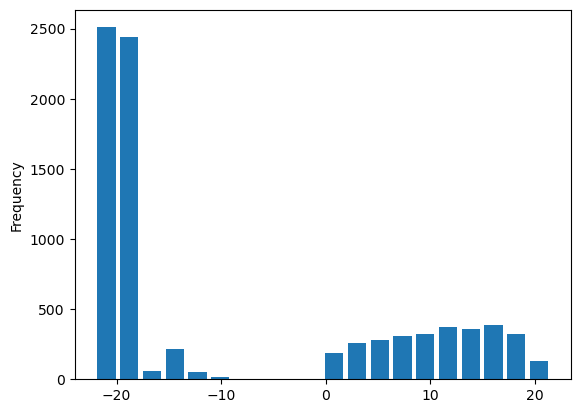

In [41]:
data.time.plot.hist(bins=20, rwidth=0.8)

In [44]:
y.value_counts()

False    6954
True     1279
Name: time, dtype: int64

##### Starker Bios bei der Rasse. Die Gruppe mit dem Eintrag 3.0 wird bei dem Model gar nicht beachtet. Sollte das ein relavantes Feature/Merkmal sein wäre das schlecht. 

<Axes: ylabel='Frequency'>

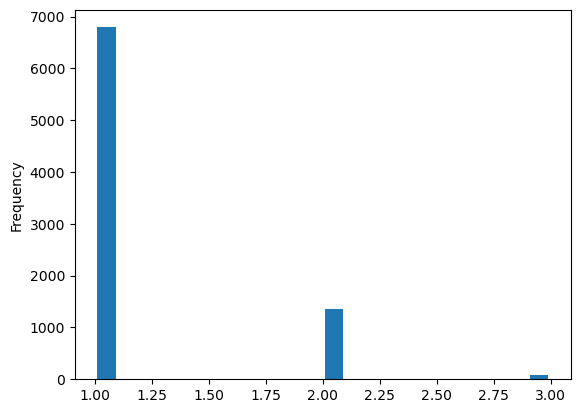

In [50]:
data.Race.plot.hist(bins=20, rwidth=0.8)

<Axes: ylabel='Frequency'>

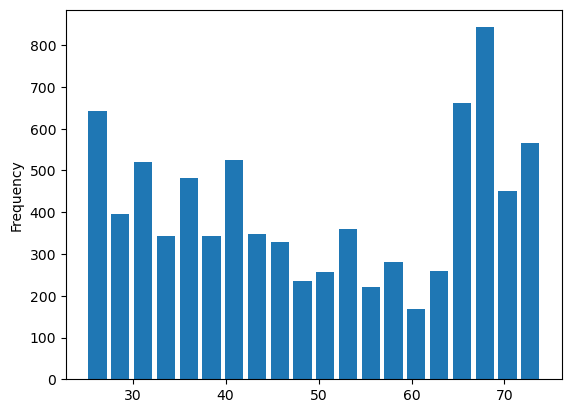

In [51]:
data.Age.plot(kind="hist", bins=20, rwidth=0.8)

# Train/Test split
### --> For now: ignore biases

Ways to better take care of those include:
- random sampling with weights
- model training with weights
- over- or under-sampling

### Train / Validation / Test

We already discussed spliting the data into a **training set** and a **test set**. Often, however, we want to have 2 different test sets. One which is the "real" test set and remains untouched and is reserved for the model evaluation. And one set which we use to optimize our model parameters. The second one is typically called **validation set**.

In [52]:
# first split --> get test set
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state = 10) #random_state = 10 sorgt dafür das wir beim nächsten training die gleichen daten bekommen?

In [53]:
# second split --> train / validation
X_train, X_val, y_train, y_val = train_test_split(X_dev,y_dev,test_size=0.25, random_state=10)

In [56]:
X_train.shape, X_test.shape, X_val.shape

((4939, 18), (1647, 18), (1647, 18))

Use the next cell to look at an individual case get familiar with the features.

In [62]:
i = 3
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           84.000000
Poverty index         151.000000
Race                    1.000000
Red blood cells        46.800000
Sedimentation rate     18.000000
Serum Albumin           4.400000
Serum Cholesterol     192.000000
Serum Iron             87.000000
Serum Magnesium         1.440000
Serum Protein           7.300000
Sex                     2.000000
Systolic BP           132.000000
TIBC                  368.000000
TS                     23.600000
White blood cells       7.200000
BMI                    28.108325
Pulse pressure         48.000000
Name: 5358, dtype: float64

Died within 10 years? True


<a name='4'></a>
## 4. Training a decision tree model

Scikit-learn provides numerous differnt machine learning models and tools. This is very convenient to use, in particular because many elements of scikit-learn can be used in (more or less) the same way. 

For more details, please look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

The model we will use first in this notebook is a **decision tree classifier** (`DecisionTreeClassifier()`). The training of a model is again simply done by running `model.fit()`.

- Please train such a decision tree using the training set.

In [96]:
tree = DecisionTreeClassifier(random_state=10, max_depth=5)
# train the model
tree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=10)

### Two types of predictions
- final predicition / classification
- "probability" (not a real probability, but still...)

#### 1. Use the model to make a prediciton

In [87]:
y_prediced = tree.predict(X_val)
y_prediced

array([False, False, False, ..., False, False, False])

Often we can also access the output one step before the final "decision". For some models this will give us float values ("probabilites"... kind of). Here, because we use one single decision tree we will only get 1 or 0 values.

#### 2. Do the same but using `.predict_proba)
What do you get from this method?

In [91]:
y_prediced_proba = tree.predict_proba(X_val)
y_prediced_proba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

#### Compute a confusion matrix using the training set

In [93]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val,y_prediced)



array([[1220,  156],
       [ 164,  107]], dtype=int64)

#### Let's check again on the validation set (X_val)

### Alternative evaluation metric: concordance

We can also use concordance, or the C-Index for evaluation.

The C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).

More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:

$$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$



Der C Index vergleicht alle Patienten mit einem Risiko Score und schaut wie oft die Vorhersage richtig war. Bei allen korrekten Vorhersage erreicht er 1.

In [94]:
import lifelines

def cindex(y_true, scores):

    return lifelines.utils.concordance_index(y_true, scores)

In [107]:
for i in range(1, 10):
    print(i)
    tree = DecisionTreeClassifier(random_state=10, max_depth=i)
    # train the model
    tree.fit(X_train,y_train)

    # How good are the prediction according to the c-index?
    y_train_preds = tree.predict_proba(X_train)[:, 1]
    print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

    y_val_preds = tree.predict_proba(X_val)[:, 1]
    print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

1
Train C-Index: 0.7524526659370522
Val C-Index: 0.7427727838324895
2
Train C-Index: 0.8006311208393048
Val C-Index: 0.7942201042649961
3
Train C-Index: 0.8181118786462015
Val C-Index: 0.8153077533682314
4
Train C-Index: 0.8394336976701517
Val C-Index: 0.8320657770531193
5
Train C-Index: 0.8535137931786602
Val C-Index: 0.8306726272204582
6
Train C-Index: 0.8718254711594841
Val C-Index: 0.8095326847163821
7
Train C-Index: 0.8928855527343224
Val C-Index: 0.8080188578048572
8
Train C-Index: 0.9088962826867093
Val C-Index: 0.7904791148202179
9
Train C-Index: 0.9272071587758386
Val C-Index: 0.7831741289796619


<a name='ex-2'></a>
### Exercise 2 - decision tree hyperparameters

Try and find a set of hyperparameters that improves the generalization to the validation set and recompute the C-index. If you do it right, you should get C-index above 0.6 for the validation set. 

You can refer to the documentation for the sklearn [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [122]:
tree = DecisionTreeClassifier(max_depth=2)
# train your model
tree.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=2)

In [123]:
# Inspect the results
y_train_preds = tree.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = tree.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.8006311208393048
Val C-Index: 0.7942201042649961


### Inspect the trained decision tree
One of the biggest advantages of a **decision tree** model is that we can intuitively understand and inspect how it comes to its predictions.

We can, for instance, output the learned tree to see how decisions are made.

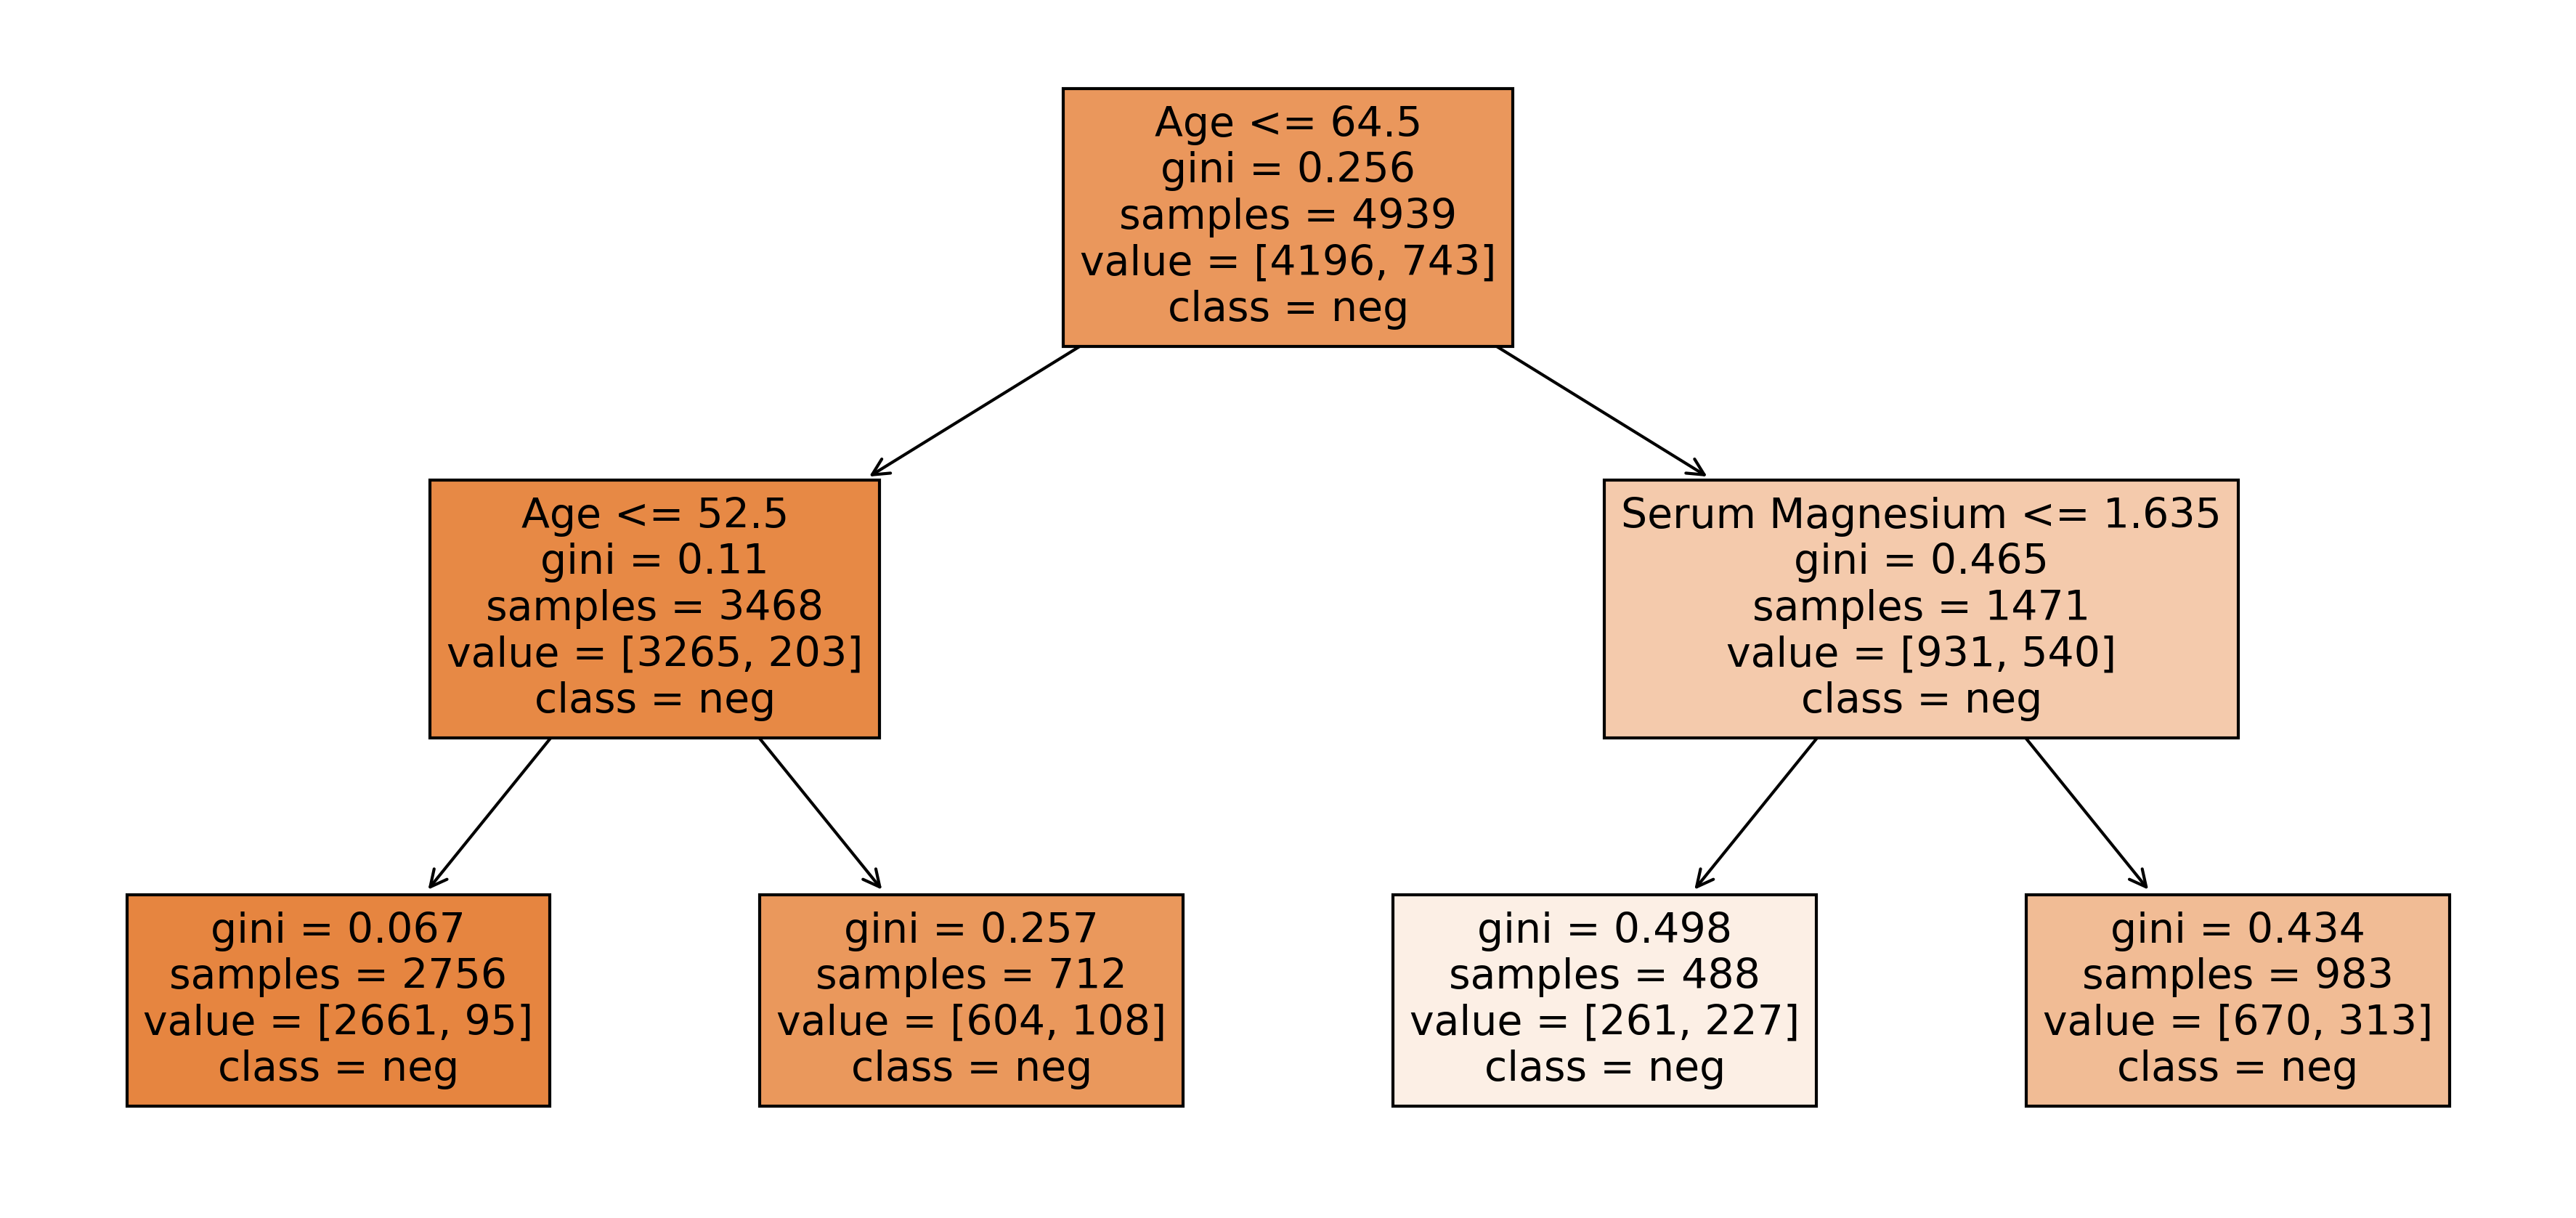

In [124]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 7), dpi=300)
plot_tree(tree, 
          feature_names=X_train.columns,  
          class_names=['neg', 'pos'],
          filled=True)

#plt.savefig("decision_tree.pdf")
plt.show()

In [130]:
tree = RandomForestClassifier(max_depth=10, n_estimators=10) #trainiert 10 Bäume und vergleicht diese, weniger anfällig für Overfitting, tendenziell besserer vorhersagekraft
# train your model
tree.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=10)

In [131]:
# Inspect the results
y_train_preds = tree.predict_proba(X_train)[:, 1]
print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")

y_val_preds = tree.predict_proba(X_val)[:, 1]
print(f"Val C-Index: {cindex(y_val.values, y_val_preds)}")

Train C-Index: 0.9741000209133354
Val C-Index: 0.8221394168883549
